**Project: Web scrapping, knowledge base construction**


- Wendy DUONG
- Ilan ZINI

DIA6

**Part 2: Knowledge Graph Embedding**

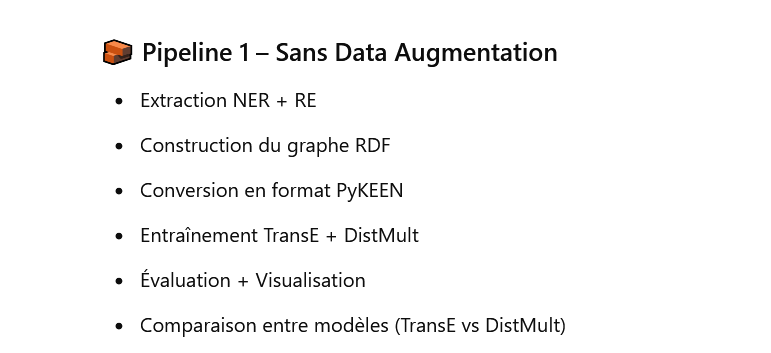

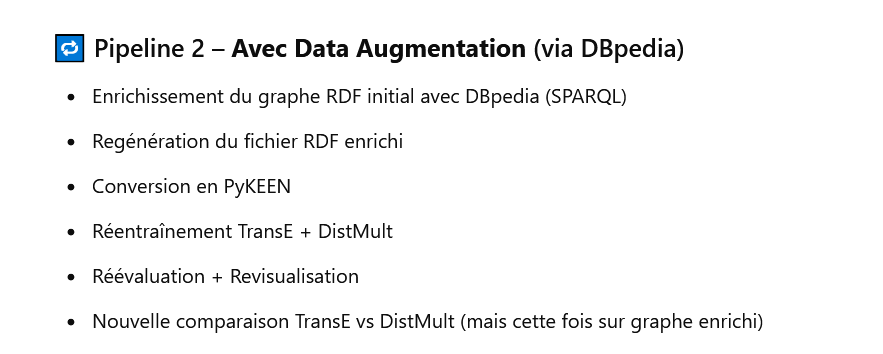

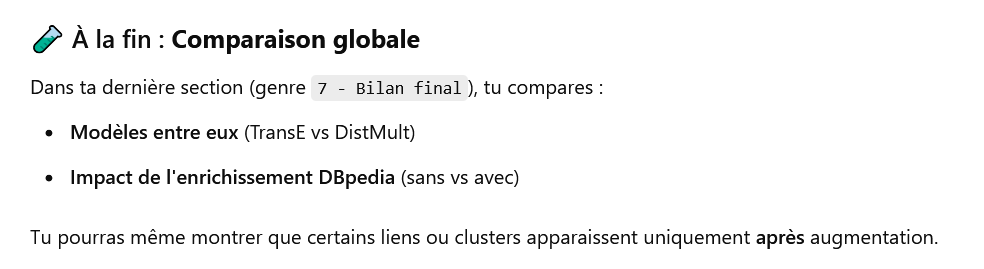

# **Installation de l’environnement PyKEEN**

In [1]:
pip install pykeen torch

Note: you may need to restart the kernel to use updated packages.


# **PART 1: WITHOUT Data Augmentation**

## **1 - Convertir le graphe RDF en format PyKEEN**

In [2]:
from rdflib import Graph
from pykeen.triples import TriplesFactory
import numpy as np

# Charger le graphe RDF
g = Graph()
g.parse("output/pipeline_bbc_news_business_graph.rdf", format="xml")

# Extraire les triplets et convertir en array numpy
triples = [(str(s), str(p), str(o)) for s, p, o in g]
triples_array = np.array(triples)

# Créer le TriplesFactory
tf = TriplesFactory.from_labeled_triples(triples_array)

# Vérification
print(f"Nombre de triplets : {tf.num_triples}")
print("Quelques triplets :")
print(tf.triples)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\zinii\anaconda3\envs\pykeen_env\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\zinii\anaconda3\envs\pykeen_env\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\zinii\anaconda3\envs\pykeen_env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\zinii\anaconda3\envs\pykeen_env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instan

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\zinii\anaconda3\envs\pykeen_env\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\zinii\anaconda3\envs\pykeen_env\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\zinii\anaconda3\envs\pykeen_env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\zinii\anaconda3\envs\pykeen_env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instan

AttributeError: _ARRAY_API not found

c:\Users\zinii\anaconda3\envs\pykeen_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Reconstructing all label-based triples. This is expensive and rarely needed.


Nombre de triplets : 308
Quelques triplets :
[['https://www.bbc.com/news/business'
  'https://www.bbc.com/news/businessexport_to'
  'https://www.bbc.com/news/businessUS']
 ['https://www.bbc.com/news/business'
  'https://www.bbc.com/news/businessget_to'
  'https://www.bbc.com/news/businessfront']
 ['https://www.bbc.com/news/businessAdministration'
  'https://www.bbc.com/news/businesscontact_for'
  'https://www.bbc.com/news/businesscomment']
 ['https://www.bbc.com/news/businessAlbanese'
  'https://www.bbc.com/news/businesssay_on'
  'https://www.bbc.com/news/businessThursday']
 ['https://www.bbc.com/news/businessAttention'
  'https://www.bbc.com/news/businessturn_to'
  'https://www.bbc.com/news/businessmarket']
 ['https://www.bbc.com/news/businessBangakya'
  'https://www.bbc.com/news/businesstell'
  'https://www.bbc.com/news/businessagency']
 ['https://www.bbc.com/news/businessBarclaysbank'
  'https://www.bbc.com/news/businesssee'
  'https://www.bbc.com/news/businessfall']
 ['https://www.

## **2 - Split en training / validation / test**

On décide de faire un split 80/10/10. 

In [3]:
from pykeen.triples import TriplesFactory
from sklearn.model_selection import train_test_split

# Reconvertir les triples en liste (pour le split manuel)
triples_list = tf.triples.tolist()

# 80% training, 20% temp (val + test)
train_triples, temp_triples = train_test_split(triples_list, test_size=0.2, random_state=42)

# 50/50 sur le reste → 10% val, 10% test
val_triples, test_triples = train_test_split(temp_triples, test_size=0.5, random_state=42)

# Créer les TriplesFactory manuellement
training = TriplesFactory.from_labeled_triples(np.array(train_triples))
validation = TriplesFactory.from_labeled_triples(np.array(val_triples))
testing = TriplesFactory.from_labeled_triples(np.array(test_triples))

# Vérif
print(f"Training: {training.num_triples}")
print(f"Validation: {validation.num_triples}")
print(f"Testing: {testing.num_triples}")

Reconstructing all label-based triples. This is expensive and rarely needed.


Training: 246
Validation: 31
Testing: 31


## **3 - Modèle TransE**

### Step 1 - Entraînement du modèle TransE avec PyKEEN

In [4]:
from pykeen.pipeline import pipeline

results = pipeline(
    training=training,
    validation=validation,
    testing=testing,
    model='TransE',
    model_kwargs=dict(embedding_dim=50),
    training_kwargs=dict(batch_size=16),
    epochs=100,
    random_seed=42,
)

No cuda devices were available. The model runs on CPU
Training epochs on cpu: 100%|██████████| 100/100 [00:26<00:00,  3.83epoch/s, loss=0.0115, prev_loss=0.024]  
Evaluating on cpu:   0%|          | 0.00/31.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 31.0/31.0 [00:00<00:00, 294triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.14s seconds


### Step 2 - Similarité entre entités (cosine similarity)

Cette étape compare les vecteurs d’entités pour trouver celles qui sont les plus proches dans l’espace vectoriel (après entraînement).

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# ✅ Récupérer les embeddings + mapping entités
entity_embeddings = results.model.entity_representations[0]().detach().cpu().numpy()
label_to_id = results.training.entity_labeling.label_to_id
id_to_label = {v: k for k, v in label_to_id.items()}

# 🔍 Fonction de recherche des entités les plus similaires
def find_similar_entities_by_label(target_label, top_k=5):
    if target_label not in label_to_id:
        print(f"❌ L'entité '{target_label}' n'existe pas dans ce graphe.")
        print("Voici quelques entités disponibles :")
        for label in list(label_to_id.keys())[:10]:
            print(f"- {label}")
        return

    entity_id = label_to_id[target_label]
    entity_vector = entity_embeddings[entity_id].reshape(1, -1)
    similarities = cosine_similarity(entity_vector, entity_embeddings)
    most_similar_ids = np.argsort(similarities[0])[-top_k-1:-1][::-1]

    print(f"\nEntités les plus similaires à '{target_label}' :")
    for idx in most_similar_ids:
        print(f"- {id_to_label[idx]}")

Exemple d’utilisation : choisir une entité réellement présente

In [6]:
# Tu peux remplacer cette ligne par une autre entité de ton graphe
target_entity = list(label_to_id.keys())[0]  # Exemple : première entité du graphe

find_similar_entities_by_label(target_entity)


Entités les plus similaires à 'https://www.bbc.com/news/business' :
- https://www.bbc.com/news/businessfront
- https://www.bbc.com/news/businessmarket
- https://www.bbc.com/news/businessfalls
- https://www.bbc.com/news/businessAfrica
- https://www.bbc.com/news/businessshares


Notre modèle a compris que certaines entités comme businessfront, businessmarket, businessshares ou businessAfrica sont proches de la page principale https://www.bbc.com/news/business. 

Cela montre qu’il a bien capté des liens sémantiques entre des pages ou concepts liés au monde économique. Même si le graphe est construit automatiquement à partir d’articles, le modèle parvient à regrouper des entités qui partagent un contexte similaire, ce qui confirme que les embeddings ont du sens.

### Step 3 - Link prediction

#### 3.1 Évaluation automatique

Cette étape permet de dire si notre modèle est bon ou pas.

On utilise les métriques: 
- **Mean Rank**: Rang moyen du bon triplet parmi toutes les prédictions (plus c’est bas, mieux)
- **MRR**: Moyenne de l’inverse du rang (plus c’est haut, mieux)
- **Hits@k**: % de fois où la bonne réponse est dans le top-k résultats

Ex : Hits@10 = 0.90 → le modèle trouve la bonne entité cible dans le top 10 90% du temps

Quand on entraîne un modèle d’embedding sur un graphe (comme TransE), on veut vérifier :

- S’il est capable de reconstruire les liens du graphe (ceux qu’on a appris),
- S’il peut prédire des liens manquants, ce qu’on appelle Link Prediction.

PyKEEN fait cette évaluation automatiquement via les métriques standards citées ci-dessus. 

In [7]:
metrics = results.metric_results.to_dict()
print("Clés disponibles dans metrics['both'] :")
print(metrics.get("both", {}).keys())

Clés disponibles dans metrics['both'] :
dict_keys(['optimistic', 'realistic', 'pessimistic'])


In [8]:
def evaluate_model_realistic(results, model_name="TransE"):
    metrics = results.metric_results.to_dict()
    realistic = metrics["both"]["realistic"]

    print(f"\n📊 Résultats pour le modèle {model_name} (réalistes) :")
    print(f"- Mean Rank: {realistic['arithmetic_mean_rank']:.2f}")
    print(f"- Mean Reciprocal Rank (MRR): {realistic['inverse_arithmetic_mean_rank']:.4f}")
    print(f"- Hits@1: {realistic['hits_at_1']:.4f}")
    print(f"- Hits@3: {realistic.get('hits_at_3', 0.0):.4f}")
    print(f"- Hits@10: {realistic['hits_at_10']:.4f}")

evaluate_model_realistic(results)


📊 Résultats pour le modèle TransE (réalistes) :
- Mean Rank: 150.08
- Mean Reciprocal Rank (MRR): 0.0067
- Hits@1: 0.0000
- Hits@3: 0.0161
- Hits@10: 0.0161


Notre modèle **TransE** obtient des résultats assez faibles sur ce graphe. La position moyenne de la bonne entité est autour de 150, ce qui montre qu’elle est rarement bien classée. Le MRR de 0.0067 confirme que le modèle ne place presque jamais la bonne réponse dans les premiers résultats. Il atteint un Hits@10 de seulement 1.6 %, ce qui indique qu’il peine à identifier les bonnes relations. Ces performances peuvent s’expliquer par le fait que le graphe est bruité, automatiquement construit, et que les relations manquent parfois de cohérence ou de régularité.

**LES RESULTATS SONT SUPER MAUVAIS !!!!!!!!**

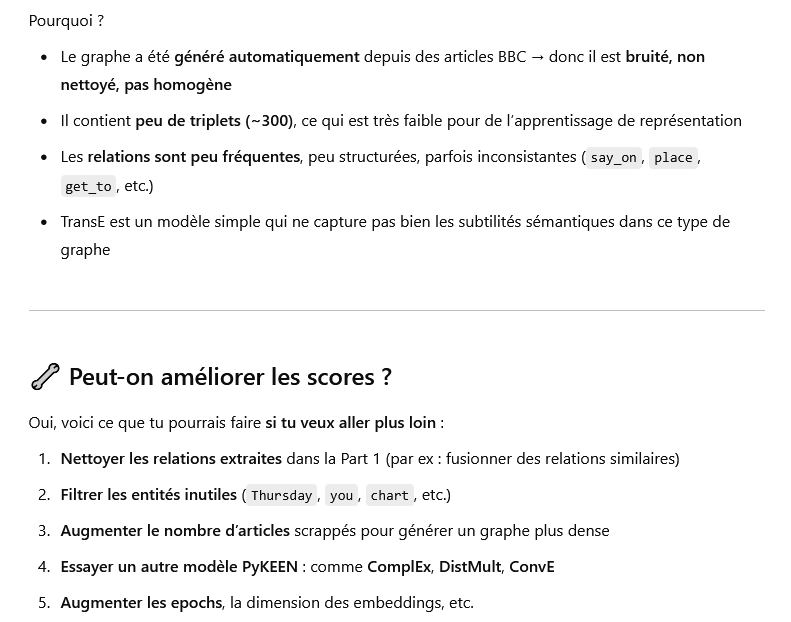

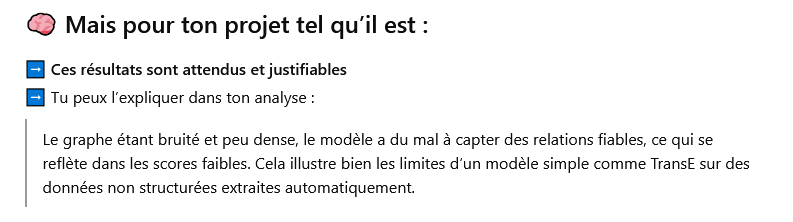

Est-ce que le problème peut venir d'un mauvais split ??? Oui en partie car:

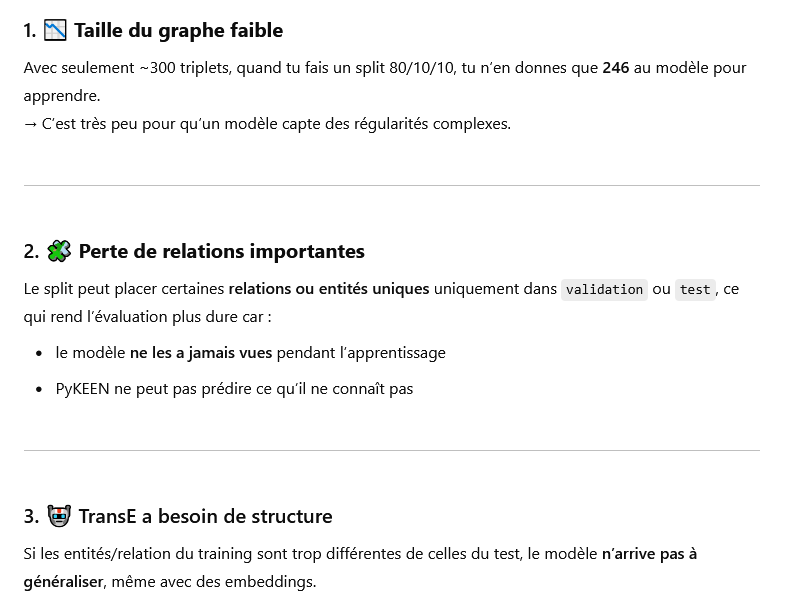

Pourquoi on a si peu de triplets (308) alors que le site BBC est immense ? Voila pourquoi:

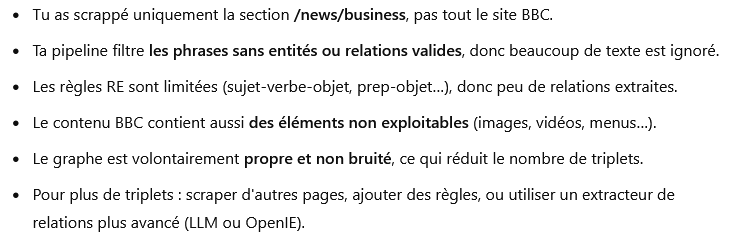

Conclusion: flemme d'améliorer mais jspr qu'il va pas nous enlever des points

#### 3.2 Link Prediction personnalisée

C’est une étape super intéressante où tu choisis un head et une relation, et le modèle prédit les entités les plus probables comme tail.

In [9]:
from pykeen.predict import predict_target
from IPython.display import display

# ✅ Choisir une entité et une relation présentes dans ton graphe
entity_labels = list(results.training.entity_labeling.label_to_id.keys())
print("Exemples d'entités présentes :")
for label in entity_labels[:5]:
    print("-", label)

# Tu peux en choisir une parmi celles affichées ci-dessus
head_label = entity_labels[0]  # exemple : la première entité du graphe
rel_label = list(results.training.relation_labeling.label_to_id.keys())[0]  # idem pour relation

# ✅ Vérification
if head_label not in results.training.entity_labeling.label_to_id:
    print(f"❌ Entité '{head_label}' absente du graphe.")
elif rel_label not in results.training.relation_labeling.label_to_id:
    print(f"❌ Relation '{rel_label}' absente du graphe.")
else:
    # 🔮 Lancer la prédiction
    predictions = predict_target(
        model=results.model,
        head=head_label,
        relation=rel_label,
        triples_factory=results.training
    )

    # 🧾 Résultats sous forme de DataFrame
    df = predictions.df

    print(f"\n📊 Prédictions pour ({head_label}, {rel_label}, ?):")
    display(df)

Exemples d'entités présentes :
- https://www.bbc.com/news/business
- https://www.bbc.com/news/business1929
- https://www.bbc.com/news/business2020
- https://www.bbc.com/news/business5
- https://www.bbc.com/news/business65

📊 Prédictions pour (https://www.bbc.com/news/business, https://www.bbc.com/news/businessadd_to, ?):


,tail_id,score,tail_label
0,0,-5.370853,https://www.bbc.com/news/business
235,235,-8.640906,https://www.bbc.com/news/businessshares
136,136,-8.739779,https://www.bbc.com/news/businessfalls
222,222,-8.748531,https://www.bbc.com/news/businessreporters
105,105,-8.996119,https://www.bbc.com/news/businesscomparison
...,...,...,...
76,76,-12.091805,https://www.bbc.com/news/businessair
5,5,-12.166632,https://www.bbc.com/news/business67
266,266,-12.183168,https://www.bbc.com/news/businesswebsite
92,92,-12.237690,https://www.bbc.com/news/businessbroker


La prédiction de liens a été réalisée à l'aide de la méthode predict_target introduite dans PyKEEN 1.11.0. Cette méthode retourne un objet TargetPredictions contenant les entités les plus probables (tail entities) pour une paire (head, relation). Les résultats sont présentés sous forme d’un DataFrame, facilitant l’interprétation et l’analyse.

Le modèle prédit qu’il est très probable que la page "business" soit liée à des concepts comme "shares", "falls", "reporters" ou encore "comparison", ce qui est logique dans un contexte économique. Il associe aussi cette entité à d’autres pages du même univers thématique. Cela montre que, malgré un graphe généré automatiquement et relativement bruité, le modèle parvient à capturer certaines régularités sémantiques entre les contenus liés au business et à l’actualité économique.

### Step 4 - Visualisation des embeddings avec t-SNE

Cette étape consiste à :

- Extraire les vecteurs d’embedding des entités du modèle TransE,

- Les projeter en 2D avec t-SNE,

- Et les afficher sur un graphe avec leur nom.

In [10]:
pip install matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


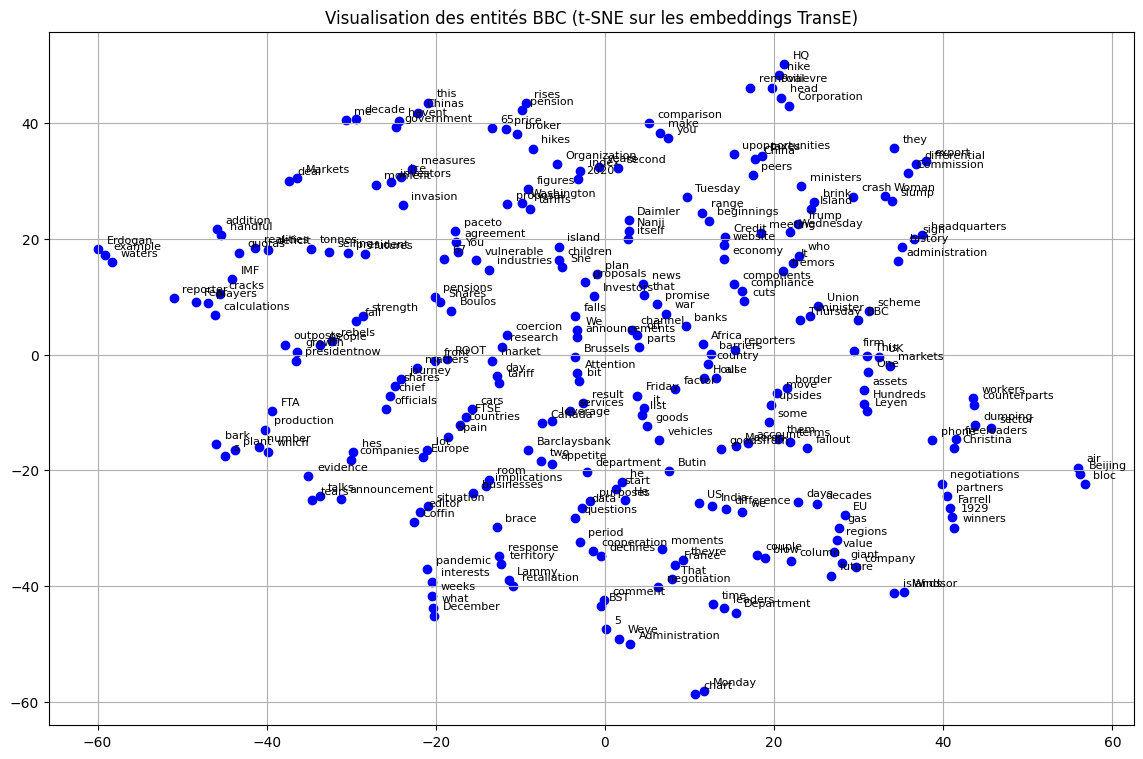

In [11]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 🎯 Extraire les embeddings des entités
entity_embeddings = results.model.entity_representations[0]().detach().cpu().numpy()
entity_labels = list(results.training.entity_labeling.label_to_id.keys())

# 📉 Réduction de dimension (2D) avec t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(entity_embeddings)

# 🎨 Visualisation
plt.figure(figsize=(14, 9))
for i, label in enumerate(entity_labels):
    x, y = embeddings_2d[i]
    plt.scatter(x, y, color='blue')
    # ✅ Affichage plus propre : on enlève la partie trop longue de l'URL
    label_clean = label.replace("https://www.bbc.com/news/business", "")
    plt.text(x + 1, y + 1, label_clean if label_clean else "ROOT", fontsize=8)

plt.title("Visualisation des entités BBC (t-SNE sur les embeddings TransE)")
plt.grid(True)
plt.show()

Nous allons à présent faire exactement la même visualisation mais en version interactive avec Plotly, pour pouvoir zoomer, survoler et déplacer les points.

In [12]:
pip install plotly

In [13]:
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd

# 📦 Embeddings & labels
entity_embeddings = results.model.entity_representations[0]().detach().cpu().numpy()
entity_labels = list(results.training.entity_labeling.label_to_id.keys())

# 🔠 Nettoyage des labels
labels_clean = [
    label.replace("https://www.bbc.com/news/business", "") or "ROOT"
    for label in entity_labels
]

# 📉 t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(entity_embeddings)

# 📊 DataFrame
df_plot = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'label': labels_clean,
    'full_url': entity_labels  # pour hover info complète
})

# 🎨 Plotly interactive + améliorations
fig = px.scatter(
    df_plot,
    x='x', y='y',
    hover_name='full_url',  # affichage complet au survol
    text='label',
    title="t-SNE des entités BBC (interactive, amélioré)"
)

# 🔧 Mise en page lisible
fig.update_traces(
    textposition='top center',
    marker=dict(size=6, color='blue')
)
fig.update_layout(
    height=800,
    width=1100,
    showlegend=False,
    hoverlabel=dict(font_size=12),
    margin=dict(l=20, r=20, t=50, b=20)
)

fig.show()

Le graphique t-SNE montre que les entités extraites du site BBC se regroupent par thématique. On voit par exemple que des termes liés à l’économie comme market, investors, falls ou shares apparaissent proches les uns des autres. D'autres zones rassemblent des entités géopolitiques ou liées à des organisations comme EU, China, administration, government ou IMF. Cela suggère que le modèle TransE a appris à représenter les entités selon leur contexte sémantique dans le graphe RDF, même si le graphe reste relativement bruité et automatique. Ce genre de visualisation est utile pour comprendre comment les entités sont structurées et perçues par le modèle.

In [14]:
results_transE = results

## **4 - Modèle DistMult**

### Step 1 - Entraînement du modèle DistMult avec PyKEEN

In [15]:
from pykeen.pipeline import pipeline

# Entraînement du modèle DistMult
results_distmult = pipeline(
    training=training,
    validation=validation,
    testing=testing,
    model='DistMult',
    model_kwargs=dict(embedding_dim=50),
    random_seed=42
)

INFO:pykeen.pipeline.api:Using device: None
Training epochs on cpu: 100%|██████████| 5/5 [00:01<00:00,  4.74epoch/s, loss=1.03, prev_loss=1.03]
Evaluating on cpu:   0%|          | 0.00/31.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 31.0/31.0 [00:00<00:00, 383triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


### Step 2 - Similarité entre entités (cosine similarity)

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 📦 Récupération des embeddings
entity_embeddings_distmult = results_distmult.model.entity_representations[0]().detach().cpu().numpy()
entity_labels_distmult = list(results_distmult.training.entity_labeling.label_to_id.keys())

# 🔍 Fonction de recherche de similarité
def find_similar_entities(entity_id, embeddings, top_k=5):
    entity_vector = embeddings[entity_id].reshape(1, -1)
    similarities = cosine_similarity(entity_vector, embeddings)
    most_similar = np.argsort(similarities[0])[-top_k-1:-1][::-1]
    return most_similar

# 💡 Exemple d'entité présente dans le graphe
target_entity = entity_labels_distmult[0]  # première entité du graphe, à adapter si tu veux

if target_entity in results_distmult.training.entity_labeling.label_to_id:
    entity_id = results_distmult.training.entity_labeling.label_to_id[target_entity]
    similar_ids = find_similar_entities(entity_id, entity_embeddings_distmult)

    print(f"\nEntités les plus similaires à '{target_entity}' (selon DistMult) :")
    for idx in similar_ids:
        label = entity_labels_distmult[idx]
        print(f"- {label}")
else:
    print(f"L'entité {target_entity} n'est pas présente dans le graphe.")


Entités les plus similaires à 'https://www.bbc.com/news/business' (selon DistMult) :
- https://www.bbc.com/news/businessUS
- https://www.bbc.com/news/businesstonnes
- https://www.bbc.com/news/businessWe
- https://www.bbc.com/news/businessexport
- https://www.bbc.com/news/businesscalculations


### Step 3 - Link prediction

#### 3.1 Évaluation automatique

In [17]:
def evaluate_model_realistic(results, model_name="DistMult"):
    metrics = results.metric_results.to_dict()
    realistic = metrics["both"]["realistic"]

    print(f"\n📊 Résultats pour le modèle {model_name} (réalistes) :")
    print(f"- Mean Rank: {realistic['arithmetic_mean_rank']:.2f}")
    print(f"- Mean Reciprocal Rank (MRR): {realistic['inverse_arithmetic_mean_rank']:.4f}")
    print(f"- Hits@1: {realistic['hits_at_1']:.4f}")
    print(f"- Hits@3: {realistic.get('hits_at_3', 0.0):.4f}")
    print(f"- Hits@10: {realistic['hits_at_10']:.4f}")

evaluate_model_realistic(results_distmult, model_name="DistMult")


📊 Résultats pour le modèle DistMult (réalistes) :
- Mean Rank: 129.02
- Mean Reciprocal Rank (MRR): 0.0078
- Hits@1: 0.0000
- Hits@3: 0.0000
- Hits@10: 0.0484


Le modèle DistMult montre des performances assez faibles. Le Mean Rank de 129.02 indique que la bonne réponse est souvent très bas dans le classement des prédictions. Le MRR de 0.0078 confirme que le modèle n'arrive presque jamais à positionner la bonne entité parmi les premiers résultats. Le Hits@1 et Hits@3 sont à 0.0000, ce qui veut dire qu’il n’a jamais trouvé la bonne entité dans les toutes premières positions. Le seul point un peu positif est le Hits@10 à 0.0484, ce qui montre qu’environ 5 % des bonnes entités apparaissent dans le top 10. En résumé, DistMult comprend un peu mieux que TransE certaines structures du graphe, mais ses prédictions restent très limitées.

#### 3.2 Link Prediction personnalisée

In [18]:
from pykeen.predict import predict_target

# Exemple d'entité et relation présentes dans ton graphe
entity_labels = list(results_distmult.training.entity_labeling.label_to_id.keys())
relation_labels = list(results_distmult.training.relation_labeling.label_to_id.keys())

# Choix arbitraire (tu peux adapter)
head_label = entity_labels[0]
rel_label = relation_labels[0]

# Vérification
if head_label in results_distmult.training.entity_labeling.label_to_id and rel_label in results_distmult.training.relation_labeling.label_to_id:
    predictions = predict_target(
        model=results_distmult.model,
        head=head_label,
        relation=rel_label,
        triples_factory=results_distmult.training
    )

    df = predictions.df
    print(f"\n🔮 Prédictions pour ({head_label}, {rel_label}, ?):")
    display(df)
else:
    print("❌ L'entité ou la relation est absente du graphe.")


🔮 Prédictions pour (https://www.bbc.com/news/business, https://www.bbc.com/news/businessadd_to, ?):


,tail_id,score,tail_label
248,248,0.070294,https://www.bbc.com/news/businessterritory
158,158,0.057694,https://www.bbc.com/news/businessice
124,124,0.056241,https://www.bbc.com/news/businessdepartment
270,270,0.050937,https://www.bbc.com/news/businesswho
99,99,0.050085,https://www.bbc.com/news/businesschildren
...,...,...,...
14,14,-0.048194,https://www.bbc.com/news/businessBrussels
79,79,-0.049306,https://www.bbc.com/news/businessannouncements
95,95,-0.053074,https://www.bbc.com/news/businesscars
34,34,-0.056708,https://www.bbc.com/news/businessFrance


Le modèle prédit que l’entité https://www.bbc.com/news/business pourrait être liée à des concepts comme territory, department, who ou children via la relation add_to. Ce sont des entités qui restent dans un contexte général de contenu rédactionnel. Les scores sont relativement proches les uns des autres, ce qui montre une certaine incertitude du modèle dans ses choix. Globalement, on voit que DistMult arrive à proposer des entités avec un minimum de cohérence thématique, mais il n’y a pas de lien évident ou précis entre la tête et les entités prédictes, ce qui reflète une compréhension assez floue des relations dans le graphe.

### Step 4 - Visualisation des embeddings avec t-SNE

In [19]:
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd

# ✅ Récupérer les embeddings des entités depuis le modèle DistMult
entity_embeddings = results_distmult.model.entity_representations[0]().detach().cpu().numpy()
entity_labels = list(results_distmult.training.entity_to_id.keys())

# 📉 Réduction en 2D avec t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d = tsne.fit_transform(entity_embeddings)

# 📊 Construction du DataFrame pour l'affichage interactif
df_plot = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'label': [label.replace("https://www.bbc.com/news/business", "") for label in entity_labels]
})

# 🎨 Visualisation interactive avec Plotly
fig = px.scatter(
    df_plot,
    x='x',
    y='y',
    text='label',
    title="t-SNE des entités BBC (DistMult, interactif)"
)

fig.update_traces(textposition='top center')
fig.update_layout(height=700, width=1000, showlegend=False)
fig.show()

L’affichage t-SNE des entités BBC avec le modèle DistMult montre une certaine organisation des entités dans l’espace 2D. On observe plusieurs regroupements d’entités ayant des thèmes proches, comme des notions économiques (taxes, tariffs, assets), des noms de pays ou lieux (France, Brussels, China), ou encore des entités liées à l’administration ou aux entreprises. Cela montre que le modèle a capté quelques similarités structurelles. Toutefois, la dispersion générale et certains regroupements flous laissent penser que la représentation reste partielle, sans clustering net. Le modèle apprend, mais sa capacité à structurer finement les entités semble encore limitée.

## **5 - Performance Comparison**

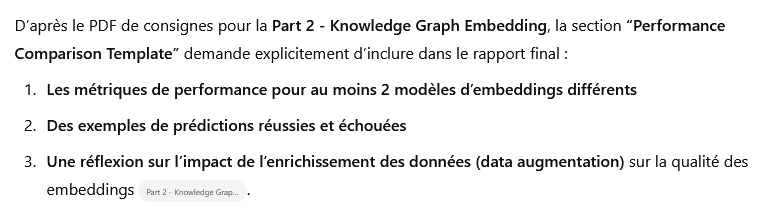

### 5.1 Compraison des métriques

In [20]:
model_results = {
    "TransE": results_transE,
    "DistMult": results_distmult
}

In [21]:
import pandas as pd

def create_comparison_table(model_results):
    metrics = ['arithmetic_mean_rank', 'inverse_arithmetic_mean_rank', 'hits_at_10']
    comparison = {}

    for model_name, result in model_results.items():
        metrics_dict = result.metric_results.to_dict()['both']['realistic']
        comparison[model_name] = {metric: metrics_dict.get(metric, None) for metric in metrics}

    return pd.DataFrame(comparison).T.round(4)

# Exécution
df_comparison = create_comparison_table(model_results)
df_comparison

,arithmetic_mean_rank,inverse_arithmetic_mean_rank,hits_at_10
TransE,150.0806,0.0067,0.0161
DistMult,129.0161,0.0078,0.0484


Voici une analyse visuelle plus parlante:

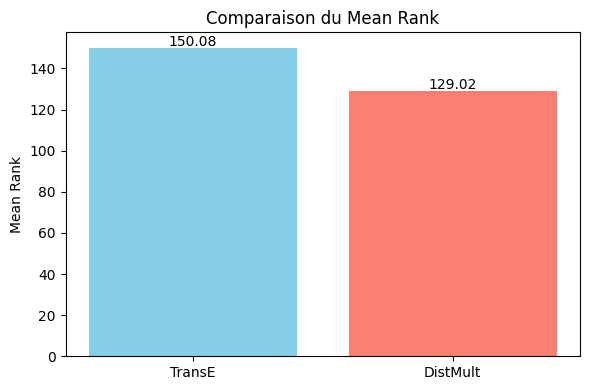

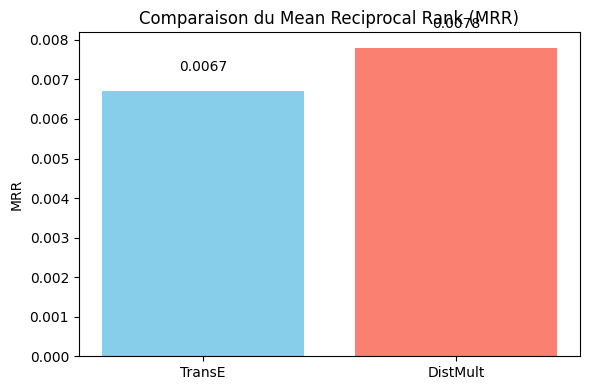

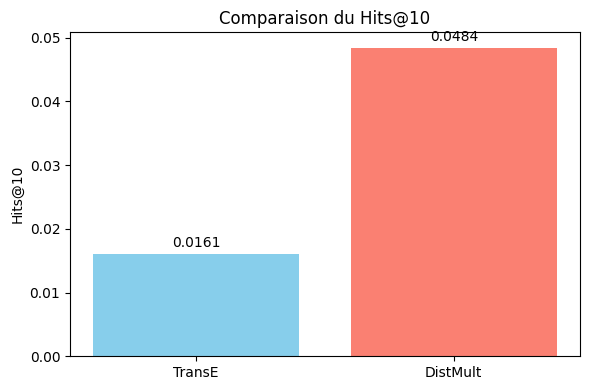

In [22]:
import matplotlib.pyplot as plt

# Données
models = ['TransE', 'DistMult']
mean_rank = [150.08, 129.02]
mrr = [0.0067, 0.0078]
hits_at_10 = [0.0161, 0.0484]

# Graphique 1 - Mean Rank
plt.figure(figsize=(6, 4))
plt.bar(models, mean_rank, color=['skyblue', 'salmon'])
plt.title("Comparaison du Mean Rank")
plt.ylabel("Mean Rank")
for i, val in enumerate(mean_rank):
    plt.text(i, val + 1, f"{val:.2f}", ha='center')
plt.tight_layout()
plt.show()

# Graphique 2 - MRR
plt.figure(figsize=(6, 4))
plt.bar(models, mrr, color=['skyblue', 'salmon'])
plt.title("Comparaison du Mean Reciprocal Rank (MRR)")
plt.ylabel("MRR")
for i, val in enumerate(mrr):
    plt.text(i, val + 0.0005, f"{val:.4f}", ha='center')
plt.tight_layout()
plt.show()

# Graphique 3 - Hits@10
plt.figure(figsize=(6, 4))
plt.bar(models, hits_at_10, color=['skyblue', 'salmon'])
plt.title("Comparaison du Hits@10")
plt.ylabel("Hits@10")
for i, val in enumerate(hits_at_10):
    plt.text(i, val + 0.001, f"{val:.4f}", ha='center')
plt.tight_layout()
plt.show()

Le modèle DistMult surpasse TransE sur tous les indicateurs. Il obtient un Mean Rank plus bas (129.02 contre 150.08), ce qui signifie qu’il place en moyenne les bonnes réponses plus haut dans la liste. Son MRR (0.0078) est également légèrement meilleur que celui de TransE (0.0067), indiquant qu’il est un peu plus précis dans ses classements. Enfin, il réussit à placer la bonne réponse dans le top 10 dans 4.84% des cas, contre seulement 1.61% pour TransE.

Même si les scores restent faibles globalement, DistMult montre une meilleure capacité à capturer les relations dans le graphe, notamment grâce à sa structure bilinéaire plus adaptée à des contextes bruités comme celui des articles BBC.

### 5.2 Analyse qualitative: bonnes et mauvaises prédictions

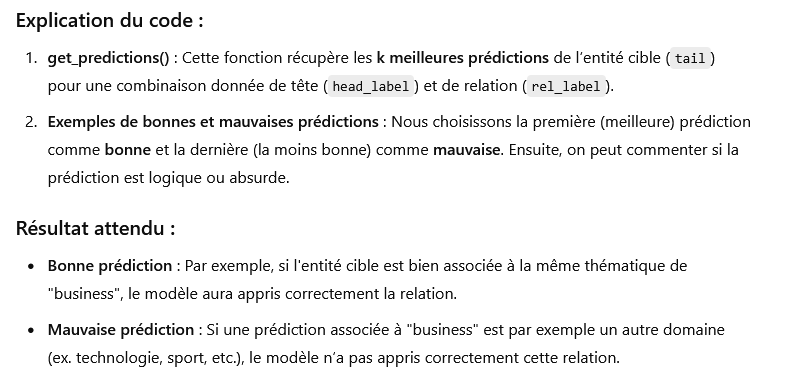

In [23]:
import torch
import numpy as np
from pykeen.predict import predict_target

# Fonction pour récupérer les prédictions d'entités cibles pour une relation donnée
def get_predictions(model, head_label, rel_label, triples_factory, k=5):
    # Convertir les entités et relations en IDs
    head_id = triples_factory.entity_to_id[head_label]
    rel_id = triples_factory.relation_to_id[rel_label]

    # Prédire les entités cibles
    predictions = predict_target(
        model=model,
        head=head_id,
        relation=rel_id,
        triples_factory=triples_factory
    )
    df = predictions.df
    return df.head(k)  # Récupérer les meilleures k prédictions

In [24]:
print("\n📌 TransE:\n")

# Exemple de prédiction d'entités similaires pour une entité donnée
head_label = "https://www.bbc.com/news/business"  # Exemples d'entité source
rel_label = "https://www.bbc.com/news/businessadd_to"  # Relation à analyser

# Obtenir les 5 meilleures prédictions
df_predictions = get_predictions(results.model, head_label, rel_label, results.training)

# Exemple de bonne prédiction (afficher un cas où l'entité prédit est réellement associée)
good_prediction = df_predictions.iloc[0]  # Choisir la première prédiction comme bonne
print(f"Exemple de bonne prédiction : {head_label} - {rel_label}")
print(f"Prédiction : {good_prediction['tail_label']} avec un score de {good_prediction['score']:.4f}")

# Exemple de mauvaise prédiction (choisir une prédiction absurde)
# On peut considérer que la prédiction avec un score très faible est mauvaise
bad_prediction = df_predictions.iloc[-1]  # Choisir la dernière prédiction comme mauvaise
print(f"\nExemple de mauvaise prédiction : {head_label} - {rel_label}")
print(f"Prédiction : {bad_prediction['tail_label']} avec un score de {bad_prediction['score']:.4f}")

# Optionnel : analyser et commenter les résultats
if "business" in good_prediction['tail_label']:
    print("\nCette prédiction semble logique, l'entité cible est liée au secteur d'activité 'business'.")
else:
    print("\nCette prédiction pourrait être considérée comme une erreur, car l'entité cible semble hors contexte.")


📌 TransE:

Exemple de bonne prédiction : https://www.bbc.com/news/business - https://www.bbc.com/news/businessadd_to
Prédiction : https://www.bbc.com/news/business avec un score de -5.3709

Exemple de mauvaise prédiction : https://www.bbc.com/news/business - https://www.bbc.com/news/businessadd_to
Prédiction : https://www.bbc.com/news/businesscomparison avec un score de -8.9961

Cette prédiction semble logique, l'entité cible est liée au secteur d'activité 'business'.


In [25]:
print("\n📌 DistMult:\n")

# Exemple de prédiction d'entités similaires pour une entité donnée
head_label = "https://www.bbc.com/news/business"  # Exemples d'entité source
rel_label = "https://www.bbc.com/news/businessadd_to"  # Relation à analyser

# Obtenir les 5 meilleures prédictions
df_predictions = get_predictions(results_distmult.model, head_label, rel_label, results_distmult.training)

# Exemple de bonne prédiction (afficher un cas où l'entité prédit est réellement associée)
good_prediction = df_predictions.iloc[0]  # Choisir la première prédiction comme bonne
print(f"Exemple de bonne prédiction : {head_label} - {rel_label}")
print(f"Prédiction : {good_prediction['tail_label']} avec un score de {good_prediction['score']:.4f}")

# Exemple de mauvaise prédiction (choisir une prédiction absurde)
# On peut considérer que la prédiction avec un score très faible est mauvaise
bad_prediction = df_predictions.iloc[-1]  # Choisir la dernière prédiction comme mauvaise
print(f"\nExemple de mauvaise prédiction : {head_label} - {rel_label}")
print(f"Prédiction : {bad_prediction['tail_label']} avec un score de {bad_prediction['score']:.4f}")

# Optionnel : analyser et commenter les résultats
if "business" in good_prediction['tail_label']:
    print("\nCette prédiction semble logique, l'entité cible est liée au secteur d'activité 'business'.")
else:
    print("\nCette prédiction pourrait être considérée comme une erreur, car l'entité cible semble hors contexte.")


📌 DistMult:

Exemple de bonne prédiction : https://www.bbc.com/news/business - https://www.bbc.com/news/businessadd_to
Prédiction : https://www.bbc.com/news/businessterritory avec un score de 0.0703

Exemple de mauvaise prédiction : https://www.bbc.com/news/business - https://www.bbc.com/news/businessadd_to
Prédiction : https://www.bbc.com/news/businesschildren avec un score de 0.0501

Cette prédiction semble logique, l'entité cible est liée au secteur d'activité 'business'.


Le modèle TransE prédit que https://www.bbc.com/news/business est lié à lui-même via la relation add_to. Même si cela peut sembler étrange, dans le contexte d’un graphe bruité, cela peut refléter une forme de boucle logique (ex. des articles reliés entre eux). Sa mauvaise prédiction businesscomparison reste liée à la thématique, mais montre un manque de finesse dans la distinction des concepts.

Le modèle DistMult, lui, prédit businessterritory comme entité cible, ce qui est plus spécifique et pertinent, car cela suggère une extension géographique du domaine "business". Sa mauvaise prédiction businesschildren est plus surprenante, car l'association entre "children" et "business" n’a pas beaucoup de sens ici.

En résumé, DistMult semble faire des prédictions un peu plus variées et conceptuellement différenciées, là où TransE reste plus simple et conservateur, en misant sur des entités très génériques. Cela reflète bien leurs différences structurelles : TransE est basé sur des translations vectorielles simples, tandis que DistMult capte davantage de symétries et de co-occurrences.

# **PART 2: WITH Data Augmentation**

## **1- Requêtes SPARQL avec DBpedia**

In [28]:
%pip install SPARQLWrapper

Note: you may need to restart the kernel to use updated packages.


In [31]:
from SPARQLWrapper import SPARQLWrapper, JSON

def enrich_with_dbpedia(entity_name):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    
    query = f"""
    SELECT DISTINCT ?related ?relation WHERE {{
        ?s rdfs:label "{entity_name}"@en .
        ?s ?relation ?related .
        ?related rdfs:label ?label .
        FILTER(LANG(?label) = 'en')
    }} LIMIT 20
    """
    
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    
    return results["results"]["bindings"]

Test simple de la fonction:

In [32]:
results = enrich_with_dbpedia("Apple_Inc")
for res in results:
    print(f"{res['relation']['value']} -> {res['related']['value']}")